In [3]:
# Initialize Otter
import otter
grader = otter.Notebook("Deblurring.ipynb")

# Matrix Analysis 2023 - EE312

## Week 4 - Image deblurring using right inverse
[LTS2](https://lts2.epfl.ch)

### Objectives
In this week's exercises you will need to use the properties of the four fundamental subspaces, as well as the left and right inverse of a matrix. The right inverse will be applied in an example to recover an image that has been degraded by a blurring operator.


## I. Exercises

<!-- BEGIN QUESTION -->

### 1.
Let $A \in \mathbb{R}^{m \times n}$ and suppose it has a left-inverse. Prove that $A^T$ has a right-inverse.

We have: $(A_L^{-1}A) = I$ If we transpose everything: $(A_L^{-1}A)^T = A^T (A_L^{-1})^T = I^T = I$. Therefore $A^T$ has a right-inverse that is: $(A_L^{-1})^T$ 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.
Let $A=\begin{pmatrix}1 & 1 & 1 &0\\1 & 2 & 2 & 1\\2 & 5 & 5 & 3\end{pmatrix}$

Compute a basis for each of its four fundamental subspaces.

1) The range of $A^T$ i.e. $\mathcal{R}(A^T)$ is the row space of $A$, we can see that $3a_1^T - a_2^T = a_3^T$ So we have two linearly independant vectors. A base for $\mathcal{R}(A^T)$ are the vectors $a_1^T, a_2^T$

2) The range of $A$ is the column space of $A$. The base for the image is: $\mathcal{R}(A) = \{a_1, a_2\}$

3) The null space of $A$ is $\mathcal{N}(A) = \mathcal{R}(A^T)^{\perp}$ i.e. 

4) The null space of $A^T$ is $\mathcal{N}(A^T) = \{a_1\times a_2\} = \{\begin{pmatrix}1&-3&1\end{pmatrix}^T\}$

<!-- END QUESTION -->

## II. Image deblurring 
### Introduction
Since we will need to visualize images, just a brief reminder on how to use matplotlib for this task

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.io
import os

We will use the `imread` function from the `scikit-image` package (pre-installed on noto, make sure to install it if you are using a local environment)

In [5]:
filename = os.path.join(skimage.data_dir, 'camera.png')
camera = skimage.io.imread(filename)

Some basic information regarding the contents of `camera`:

In [6]:
camera.shape

(512, 512)

In [7]:
camera.dtype

dtype('uint8')

The type `uint8` means each value in `camera` is represented using a single byte, and is within $[0, 255]$.

Displaying the image is fairly straightforward :

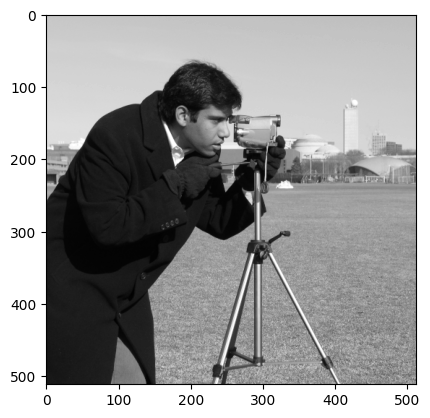

In [8]:
plt.imshow(camera, cmap='gray')
plt.show()

The image here is widely used in many image processing scientific publications.

The `cmap` parameter specifies the colormap used to display the image. Matplotlib default colormap not being grayscale, passing `cmap='gray'` is needed. You can find [several predefined colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html) in Matplotlib. 

You can also check the images distributed with `scikit-image` on their [github repository](https://github.com/scikit-image/scikit-image/tree/main/skimage/data). Feel free to use another image, or even one of your own.

## 1. Blurring operator

In order to efficiently deblur an image, let us design our own blurring operator. Since it will be entirely known, it will be possible to compute its inverse.

Let us consider an input vector $x=\begin{pmatrix}x_0 \\ x_1 \\ \vdots \\ x_{N-1}\end{pmatrix} \in \mathbb{R}^N$. 

Our blurring operator $B$ will do two things:
- replace each value $x_k$ by the average of $2p+1$ values surrounding $x_k$, i.e. between $x_{k-p}$ and $x_{k+p}$.
- compute this average not for every $x_k$ but only every $s$ values, with $s$ being a subsampling factor, $s>0$.

Formally, if we denote by $y$ the output of the blurring operator on $x$, this means that
- $y\in\mathbb{R}^M$, with $M=\frac{N}{s}$ (NOTE: we will only consider the case where $N$ is a mutiple of $s$)
- $y_m = \frac{1}{2p+1}\sum_{k=sm-p}^{sm+p}x_k$

As you may have noticed, our summation indices in the definition of $y_m$ can be negative in some cases and bigger than $N-1$ in others. In those cases the missing value of $x_k$ is replaced by 0. This way of handling borders is often referred to as **zero-padding**, as it can be achieved by creating an extended version of $x$ with a number of leading and trailing zeros. There are other ways of handling borders, e.g. by using $x_0$ for negative indices and $x_{N-1}$ for indices greater than $N-1$, or even by mirroring the input vector.

1. Write a function that creates the matrix $B$ that performs the operations described above.

Remember that in python the `//` operator performs the integer division.

**!!Warning!!** the automated tests are here to help you, they might however be incomplete and do not fully guarantee that your implementation is correct even if they all pass !

In [9]:
def blur_matrix(N, p, s):
    """
    Computes the blurring matrix 

    Parameters
    ----------
    N : length of the input signal
    p : half-length of the blurring filter
    s: subsampling factor

    Returns
    -------
    The blurring matrix 
    """
    B = np.eye(N, dtype=int)
    deleterows = []
    for i in range(N):
        if i%s == 0:
            for j in range(-p, p+1):
                if i+j >= 0 and i+j < N:
                    B[i, i+j] = 1
        else:
            deleterows.append(i)
    B = np.delete(B, deleterows, axis=0)
    return B*1/(2*p+1)

In [10]:
grader.check("q2p1")

q2p1 results: All test cases passed!
q2p1 - 1 message: Good, your implementation returns correct results

<!-- BEGIN QUESTION -->

2. What is the rank of $B$ ? 

Hint: 
- row-rank might be easier to consider
- you might also need to add constraints on $s$ and $p$

**Answer:**
- The row rank is the integer part of $N/s$

<!-- END QUESTION -->

## 2. Blurring the image

We now have our blurring matrix ready, let us use it to blur the `camera` image.
As $B$ is designed to operate on vectors, we will need two steps to blur the image
- apply $B$ on each column of the input image
- apply $B$ on each row of the column-blurred image computed above

3. Implement a function that blurs an image using the matrix defined in the previous question

In [11]:
def blur_image(img, B):
    """
    Blurs the input image using the blur matrix

    Parameters
    ----------
    img : input image
    B : blur matrix

    Returns
    -------
    The blurred image 
    """
    return (B@img)@B.T

In [12]:
grader.check("q2p3")

q2p3 results: All test cases passed!
q2p3 - 1 message: Good, your implementation returns correct results

In [13]:
# build the blur matrix
B = blur_matrix(512, 3, 2)

In [14]:
# Blur on rows
camera_blurred = blur_image(camera, B)

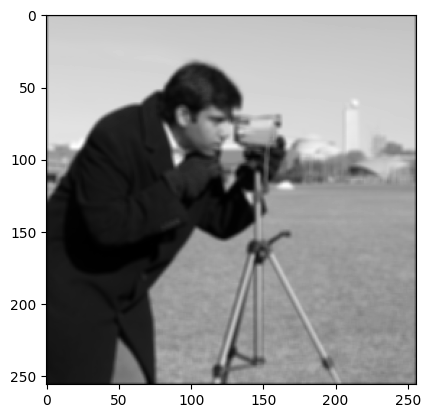

In [15]:
plt.imshow(camera_blurred, cmap='gray') # check the result
plt.show()

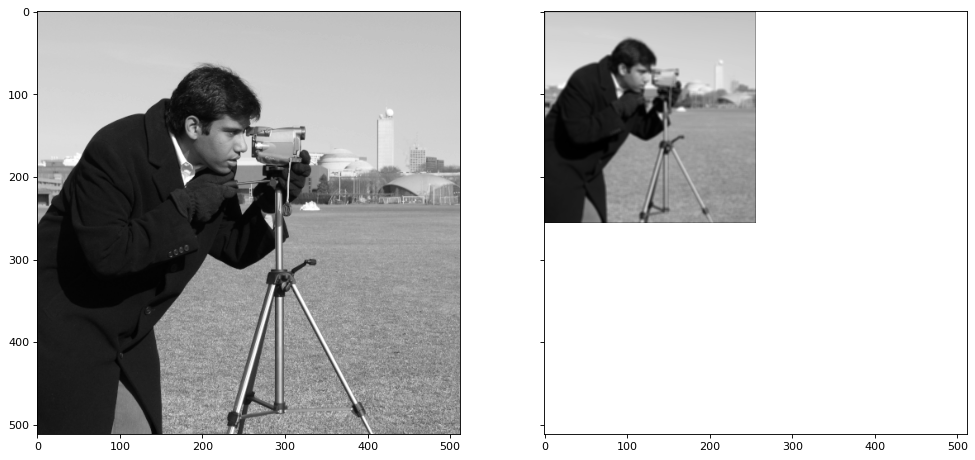

In [16]:
# Display blurred and original side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7), dpi=80, sharey=True, sharex=True)
ax[1].imshow(camera_blurred, cmap='gray')
ax[0].imshow(camera, cmap='gray')
plt.show()

## 3. Deblurring
Now everything is setup, we can proceed with the image restoration. 

<!-- BEGIN QUESTION -->

4.  Let us denote the result of a blur operation by $y=Bx$. Show that $x^* = B_R^{-1}y$, where $B_R^{-1}$ is the right-inverse of $B$, is an admissible value for $x$ to satisfy $y=Bx$. Using this result and looking at the first exercise, find a possible solution for the complete blurring operation (on both rows and columns).

If we replace $x$ by $x^*$ we get: $y = BB_R^{-1}y = y$

<!-- END QUESTION -->

5. Implement a function that computes the right inverse of the blur matrix, and uses it preform image restoration. Do not forget to consider row and columns blurring.

You can use `np.linalg.inv` to perform the inverse of a matrix.

In [17]:
def inverse_blur(blurred_img, B):
    return (B_inv := B.T@np.linalg.inv(B@B.T)) @ blurred_img @ B_inv.T

In [18]:
grader.check("q2p5")

q2p5 results: All test cases passed!
q2p5 - 1 message: Good, reblurring the unblurred image is equal to the original blurred image

Using this function, compute the reconstructed image from the blurred one

In [19]:
camera_unblur = inverse_blur(camera_blurred, B)

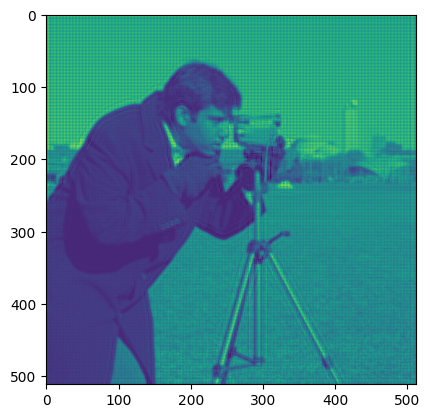

In [20]:
plt.imshow(camera_unblur) # check the result
plt.show()

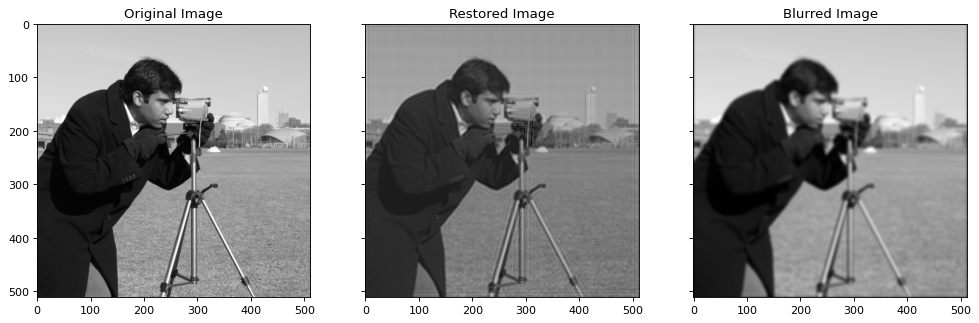

In [21]:
# Let us compare the original image, the restored image and an upscaled version of the blurred image
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7), dpi=80, sharey=True, sharex=True)
ax[0].imshow(camera, cmap='gray')
ax[1].imshow(camera_unblur, cmap='gray')
ax[2].imshow(skimage.transform.resize(camera_blurred, (512,512)), cmap='gray')
# add titles
ax[0].set_title('Original Image')
ax[1].set_title('Restored Image')
ax[2].set_title('Blurred Image')
plt.show()

<!-- BEGIN QUESTION -->

6. Evaluate the performance of the restoration method. What are its limitations for a real-world usage ? Check that the computed solution is valid by blurring the restored image.

It is not perfect, there are weird effects on the border due to the zero padding and the contrast gets less strong because we take the mean of different values and we can't restore it quite as well. The whole restored image has a checkerboard pattern because we do blur row by row and then column by column, and the values in the B matrix are all equal. To fix this issue we could apply a gaussian blur to create smoother edges and do a convolution to interlace the different results. But we do get back the basic information of the image by using a more efficient method than a convolution so the solution could be used for not very critical solutions. The reblurred restored image is the same as the blurred image, so this half does work well.

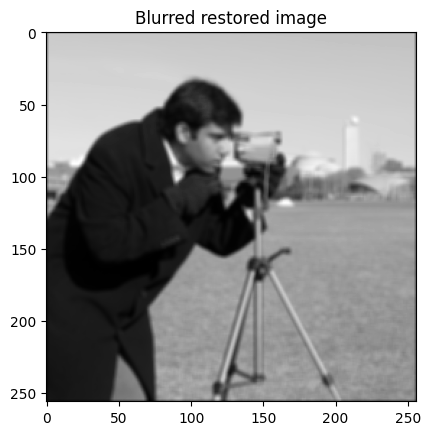

The restored blurred and the original blurred images are equal: True


In [22]:
restored_blur = blur_image(camera_unblur, B)
plt.imshow(restored_blur, cmap='gray')
plt.title('Blurred restored image')
plt.show()
print(f'The restored blurred and the original blurred images are equal: {np.allclose(restored_blur, camera_blurred)}')

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [23]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q2p1 results: All test cases passed!
    q2p1 - 1 message: Good, your implementation returns correct results

    q2p3 results: All test cases passed!
    q2p3 - 1 message: Good, your implementation returns correct results

    q2p5 results: All test cases passed!
    q2p5 - 1 message: Good, reblurring the unblurred image is equal to the original blurred image
